In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Model

In [28]:
def split_data(train_data, test_data):
    X_train, y_train = train_data.drop(columns=['hospital_death']), train_data['hospital_death']
    X_test, y_test = test_data.drop(columns=['hospital_death']), test_data['hospital_death']
    return X_train, y_train, X_test, y_test

In [29]:
def calculate_auc(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr), fpr, tpr

In [30]:
def custom_cross_val_score(model, X, y, cv=5):
    """
    Perform cross-validation manually without using existing libraries.

    Args:
        model: Machine learning model with fit and predict methods.
        X (array-like): Feature matrix (Pandas DataFrame or NumPy array).
        y (array-like): Target vector (Pandas Series or NumPy array).
        cv (int): Number of cross-validation folds.

    Returns:
        scores (list): List of AUC scores for each fold.
    """
    # Convert to NumPy arrays if needed
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    # Shuffle data
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    # Split data into folds
    fold_size = len(y) // cv
    scores = []

    for i in range(cv):
        start, end = i * fold_size, (i + 1) * fold_size
        X_val, y_val = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]], axis=0)
        y_train = np.concatenate([y[:start], y[end:]], axis=0)

        # Fit model and predict probabilities
        model.fit(X_train, y_train)
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]

        # Calculate AUC
        auc = roc_auc_score(y_val, y_val_pred_proba)
        scores.append(auc)

    return scores

def search_best_parameter(X, y, cv=5):
    # Parameter settings
    n_estimators_range = [100, 150, 200]
    max_depth_range = [10, 15, 20]

    best_auc = 0
    best_params = None
    best_model = None
    param_results = []

    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            # Model
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

            # Custom cross-validation
            auc_scores = custom_cross_val_score(model, X, y, cv=cv)
            mean_auc = np.mean(auc_scores)

            # Record the parameters and their corresponding AUC
            param_results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'mean_auc': mean_auc
            })

            if mean_auc > best_auc:
                best_auc = mean_auc
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
                best_model = model

    best_model.fit(X, y)

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation AUC: {best_auc:.4f}")

    return best_model, param_results

def plot_results(param_results):
    # Extract parameters and AUC values
    n_estimators = [result['n_estimators'] for result in param_results]
    max_depth = [result['max_depth'] for result in param_results]
    mean_auc = [result['mean_auc'] for result in param_results]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(n_estimators, max_depth, c=mean_auc, cmap='viridis', s=100, edgecolor='k')
    plt.colorbar(scatter, label='Mean AUC')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Max Depth')
    plt.title('Grid Search Results (AUC)')
    plt.show()

In [31]:
# X_train, y_train = ...  # Load your training data
# best_model, param_results = search_best_parameter_with_cv(X_train, y_train)
# plot_results(param_results)

In [32]:
# testing with best parameter
def testing_data(best_model, X_test, y_test):
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc, fpr, tpr = calculate_auc(y_test, y_test_pred_proba)
    print(f"Test AUC: {test_auc:.4f}")
    return test_auc, fpr, tpr

In [33]:
# print ROC curve
def print_roc_curve(test_auc, fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Data 01

In [34]:
train_data = pd.read_csv('../00-dataset/01-data01/train_data_1.csv')
test_data = pd.read_csv('../00-dataset/01-data01/test_data_1.csv')

print(train_data.describe())
print(test_data.describe())

                age           bmi  elective_surgery   ethnicity_0  \
count  21724.000000  21724.000000      21724.000000  21724.000000   
mean      62.480134     29.137406          0.186430      0.068450   
std       16.355643      8.118315          0.389462      0.252522   
min       16.000000     14.844926          0.000000      0.000000   
25%       53.000000     23.739572          0.000000      0.000000   
50%       64.000000     27.939368          0.000000      0.000000   
75%       75.000000     32.603647          0.000000      0.000000   
max       89.000000     67.814990          1.000000      1.000000   

        ethnicity_1   ethnicity_2      gender_0      gender_1        height  \
count  21724.000000  21724.000000  21724.000000  21724.000000  21724.000000   
mean       0.152504      0.881652      0.542119      0.457881    169.655189   
std        0.359517      0.323028      0.498234      0.498234     10.653815   
min        0.000000      0.000000      0.000000      0.000000 

Best Parameters: {'n_estimators': 150, 'max_depth': 20}
Best Cross-Validation AUC: 0.8926
Test AUC: 0.8998


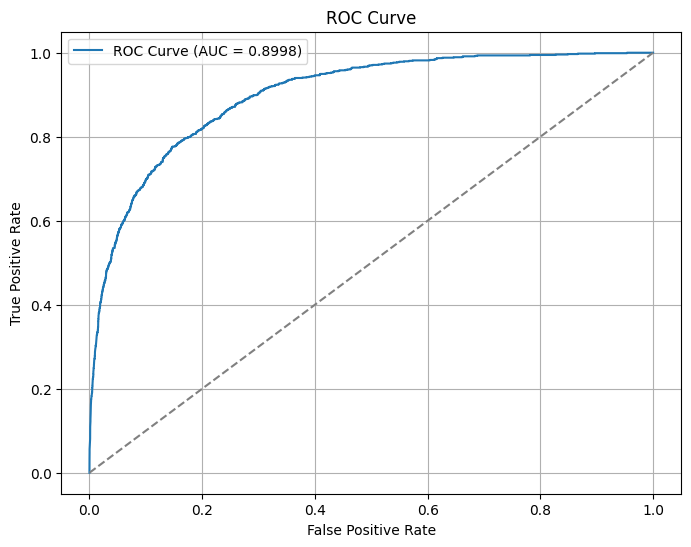

In [35]:
X_train, y_train, X_test, y_test = split_data(train_data, test_data)
best_model, param_results = search_best_parameter(X_train, y_train)
test_auc, fpr, tpr = testing_data(best_model, X_test, y_test)
print_roc_curve(test_auc, fpr, tpr)

# Data 02

In [36]:
train_data = pd.read_csv('../00-dataset/02-data02/train_data_2.csv')
test_data = pd.read_csv('../00-dataset/02-data02/test_data_2.csv')

print(train_data.describe())
print(test_data.describe())

                age           bmi  elective_surgery   ethnicity_0  \
count  27931.000000  27931.000000      27931.000000  27931.000000   
mean      63.803225     28.860383          0.154595      0.052916   
std       15.550619      7.786833          0.361525      0.223870   
min       16.000000     14.844926          0.000000      0.000000   
25%       55.660617     23.739453          0.000000      0.000000   
50%       65.485210     27.698007          0.000000      0.000000   
75%       75.109432     32.225989          0.000000      0.000000   
max       89.000000     67.814990          1.000000      1.000000   

        ethnicity_1   ethnicity_2      gender_0      gender_1        height  \
count  27931.000000  27931.000000  27931.000000  27931.000000  27931.000000   
mean       0.122767      0.924063      0.444989      0.555011    169.515914   
std        0.328175      0.264902      0.496974      0.496974     10.318071   
min        0.000000      0.000000      0.000000      0.000000 

Best Parameters: {'n_estimators': 200, 'max_depth': 20}
Best Cross-Validation AUC: 0.9765
Test AUC: 0.9797


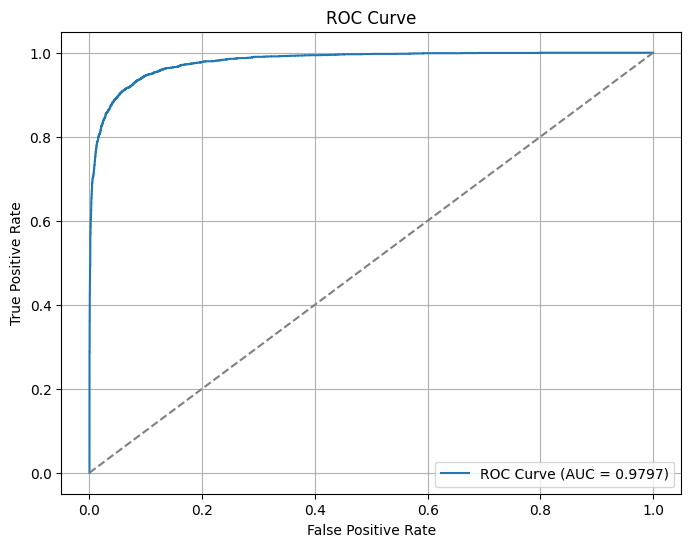

In [38]:
X_train, y_train, X_test, y_test = split_data(train_data, test_data)
best_model, param_results = search_best_parameter(X_train, y_train)
test_auc, fpr, tpr = testing_data(best_model, X_test, y_test)
print_roc_curve(test_auc, fpr, tpr)

# Data 03

In [41]:
train_data = pd.read_csv('../00-dataset/03-data03/train_data_3.csv')
test_data = pd.read_csv('../00-dataset/03-data03/test_data_3.csv')

print(train_data.describe())
print(test_data.describe())

                age           bmi  elective_surgery  ethnicity_0  \
count  39104.000000  39104.000000      39104.000000  39104.00000   
mean      65.099217     28.803030          0.121880      0.07209   
std       14.733990      7.688750          0.327151      0.25864   
min       16.000000     14.844926          0.000000      0.00000   
25%       57.906503     23.724537          0.000000      0.00000   
50%       67.000000     27.692249          0.000000      0.00000   
75%       76.000000     32.077051          0.000000      0.00000   
max       89.000000     67.814990          1.000000      1.00000   

        ethnicity_1   ethnicity_2      gender_0      gender_1        height  \
count  39104.000000  39104.000000  39104.000000  39104.000000  39104.000000   
mean       0.054854      0.962817      0.433613      0.566387    169.583509   
std        0.227697      0.189212      0.495579      0.495579      9.865438   
min        0.000000      0.000000      0.000000      0.000000    137.20

Best Parameters: {'n_estimators': 200, 'max_depth': 20}
Best Cross-Validation AUC: 0.9899
Test AUC: 0.9916


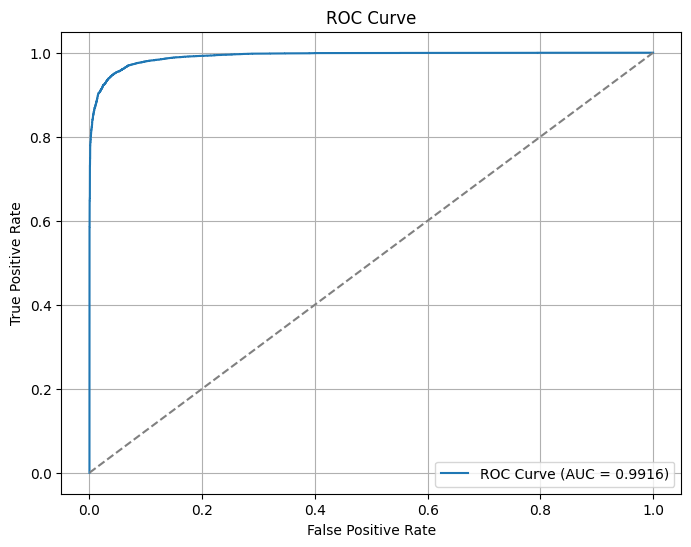

In [42]:
X_train, y_train, X_test, y_test = split_data(train_data, test_data)
best_model, param_results = search_best_parameter(X_train, y_train)
test_auc, fpr, tpr = testing_data(best_model, X_test, y_test)
print_roc_curve(test_auc, fpr, tpr)